In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
68*32

2176

In [7]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())
    print(img_batch[0])

(32, 256, 256, 3)
[0 0 0 1 0 1 1 1 1 1 1 0 2 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 0 2 2 1]
tf.Tensor(
[[[195. 193. 196.]
  [188. 186. 189.]
  [185. 183. 186.]
  ...
  [152. 146. 150.]
  [150. 144. 148.]
  [141. 135. 139.]]

 [[191. 189. 192.]
  [189. 187. 190.]
  [191. 189. 192.]
  ...
  [148. 142. 146.]
  [155. 149. 153.]
  [154. 148. 152.]]

 [[191. 189. 192.]
  [189. 187. 190.]
  [192. 190. 193.]
  ...
  [145. 139. 143.]
  [151. 145. 149.]
  [152. 146. 150.]]

 ...

 [[190. 185. 182.]
  [189. 184. 181.]
  [187. 182. 179.]
  ...
  [148. 140. 138.]
  [150. 142. 140.]
  [156. 148. 146.]]

 [[190. 185. 182.]
  [190. 185. 182.]
  [191. 186. 183.]
  ...
  [146. 138. 136.]
  [144. 136. 134.]
  [151. 143. 141.]]

 [[186. 181. 178.]
  [186. 181. 178.]
  [188. 183. 180.]
  ...
  [154. 146. 144.]
  [154. 146. 144.]
  [163. 155. 153.]]], shape=(256, 256, 3), dtype=float32)


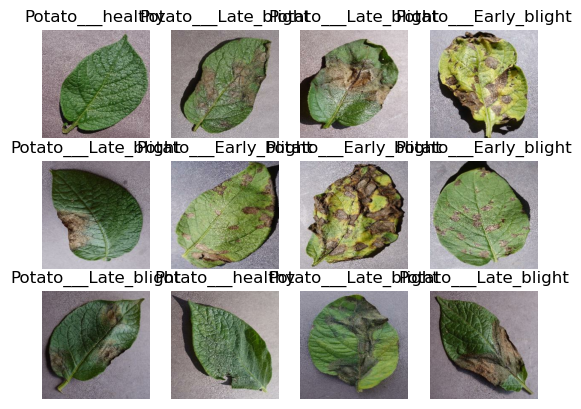

In [8]:
for img_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(img_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
#  in this we divide the dataset into training, validation and test
#  in the ratio of 80:10:10

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(ds_size*train_split)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [24]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [26]:
data_augmentaion = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])